# dHybridR M09_th45 Analysis
#### Here we analyze a specific simulation, assuming that FPC data has already been generated

This is the first time we analyze a simulation using restart data

In [1]:
#Need this to add libraries in parent folder
import sys
sys.path.append('..')
sys.path.append('.')
sys.path.append('../lib')

In [7]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [8]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/home/collbrown/dHybridR/analysis/dHybridRAnalysis/notebooks/../lib/plot/velspace.py'>

## Load data

In [9]:
#nomally we use anl.analysis_input, but here we set it by hand as we haven't computed the FPC 
#   along each x slice using generateFPC.py and thus haven't made an analysis input file 

path = '/srv/data/simulation/dHybridR/2021.05.Perp_Shocks/Batch05/M09_th45/'
resultsdir = 'M09_th45results/'
vmax = 25.0
dv = 0.5
numframe = 1000 #Not sure if restart files are for the 1000th frame or not
dx = 0.5
xlim = None
ylim = [0.0, 6.0]
zlim = [0.0, 6.0]

path_restart = path

In [10]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)


In [11]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)

In [ ]:
dparticles = dh5.read_restart(path_restart,verbose=True)

0 of 446
1 of 446
2 of 446
3 of 446
4 of 446
5 of 446
6 of 446
7 of 446
8 of 446
9 of 446
10 of 446
11 of 446
12 of 446
13 of 446
14 of 446
15 of 446
16 of 446
17 of 446
18 of 446
19 of 446
20 of 446
21 of 446
22 of 446
23 of 446
24 of 446
25 of 446
26 of 446
27 of 446
28 of 446
29 of 446
30 of 446
31 of 446
32 of 446
33 of 446
34 of 446
35 of 446
36 of 446
37 of 446
38 of 446
39 of 446
40 of 446
41 of 446
42 of 446
43 of 446
44 of 446
45 of 446
46 of 446
47 of 446
48 of 446
49 of 446
50 of 446
51 of 446
52 of 446
53 of 446
54 of 446
55 of 446
56 of 446
57 of 446
58 of 446
59 of 446
60 of 446
61 of 446
62 of 446
63 of 446
64 of 446
65 of 446
66 of 446
67 of 446


In [12]:
#make results directory
resultstag = 'M09_th45'
resultsdir = resultstag+'results/'
os.system('mkdir ' + resultsdir)

0

## Sanity Check of dparticles

In [ ]:
def debug_hist(data, xlabel = '', ylabel = 'n'):
    import matplotlib.pyplot as plt
    binsplt = np.linspace(min(data),max(data),1000)
    
    plt.figure()
    plt.hist(data, bins = binsplt)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

In [ ]:
debug_hist([pts[i][0] for i in range(0,len(pts))], xlabel = 'x')

In [ ]:
debug_hist([pts[i][1] for i in range(0,len(pts))], xlabel = 'y')

In [ ]:
debug_hist([pts[i][2] for i in range(0,len(pts))], xlabel = 'z')

In [ ]:
debug_hist([pts[i][3] for i in range(0,len(pts))], xlabel = 'vx')

In [ ]:
debug_hist([pts[i][4] for i in range(0,len(pts))], xlabel = 'vy')

In [ ]:
debug_hist([pts[i][5] for i in range(0,len(pts))], xlabel = 'vz')

### Lorentz transform fields and shift frame of flow

In [13]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


In [14]:
## (Optional) Check if shock was tracked well. We use the back half in time to fit to a line
#plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [15]:
#loretnz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

#tranform flow
dflow = ft.transform_flow(dflow,vshock)

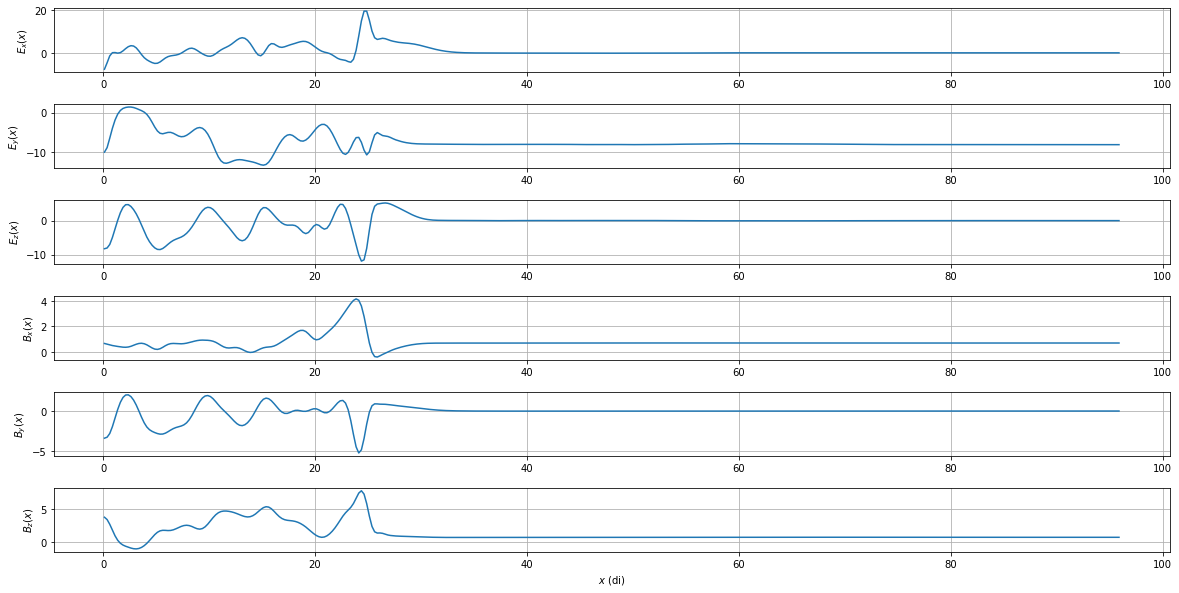

In [16]:
# (Optional) plot all the lorentz transformed fields
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, flnm=resultsdir+resultstag+'fields.png')
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

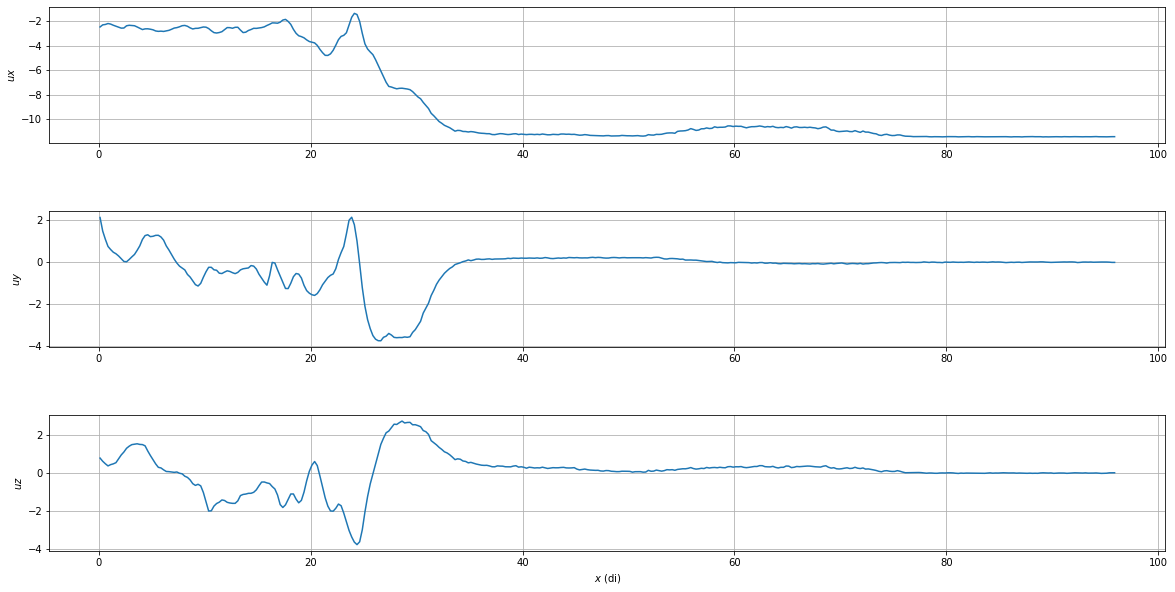

In [17]:
# (Optional) plot flow in the etimated frame of the shock
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, flnm=resultsdir+resultstag+'flow.png')
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Look for signature bounds

In [22]:
startval = 24.0#lower bound for sda metadata = 1 (di)
endval = 32.5#upper bound for sda metadata = 1 (di)

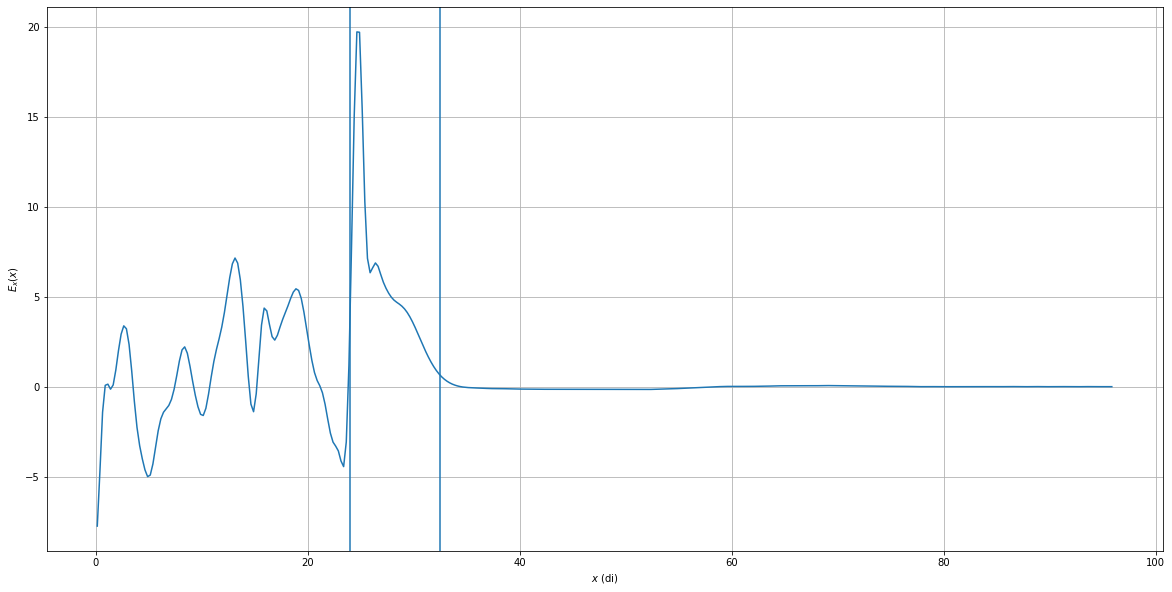

In [23]:
#option one, use Ex(x,y=0,z=0) to find SDA bounds. Should range from the start of the ramp to the first zero crossing
yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval,flnm=resultsdir+resultstag+'shockbounds.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

### Do sample FPC

In [ ]:
x1 = startval
x2 = endval
y1 = ylim[0]
y2 = ylim[1]
z1 = ylim[0]
z2 = ylim[1]

fieldkey = 'ex'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ey'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

fieldkey = 'ez'
directionkey = str(fieldkey[1])
vx, vy, vz, totalPtcl, totalFieldpts, hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, fieldkey, directionkey)

vx_xy,vy_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_xz,vz_xz = ao.mesh_3d_to_2d(vx,vy,vz,'xz')
vy_yz,vz_yz = ao.mesh_3d_to_2d(vx,vy,vz,'yz')
H_xy = ao.array_3d_to_2d(hist,'xy')
H_xz = ao.array_3d_to_2d(hist,'xz')
H_yz = ao.array_3d_to_2d(hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

In [ ]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Load FPC data

In [14]:
ncflnm = '../M09_th45results/m09_th45.nc'
Hist, CEx, CEy, CEz, vx, vy, vz, x, enerCEx, enerCEy, enerCEz, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(ncflnm)

### Look for signature bounds

In [15]:
startval = 19.0#lower bound for sda metadata = 1 (di)
endval = 25.5#upper bound for sda metadata = 1 (di)

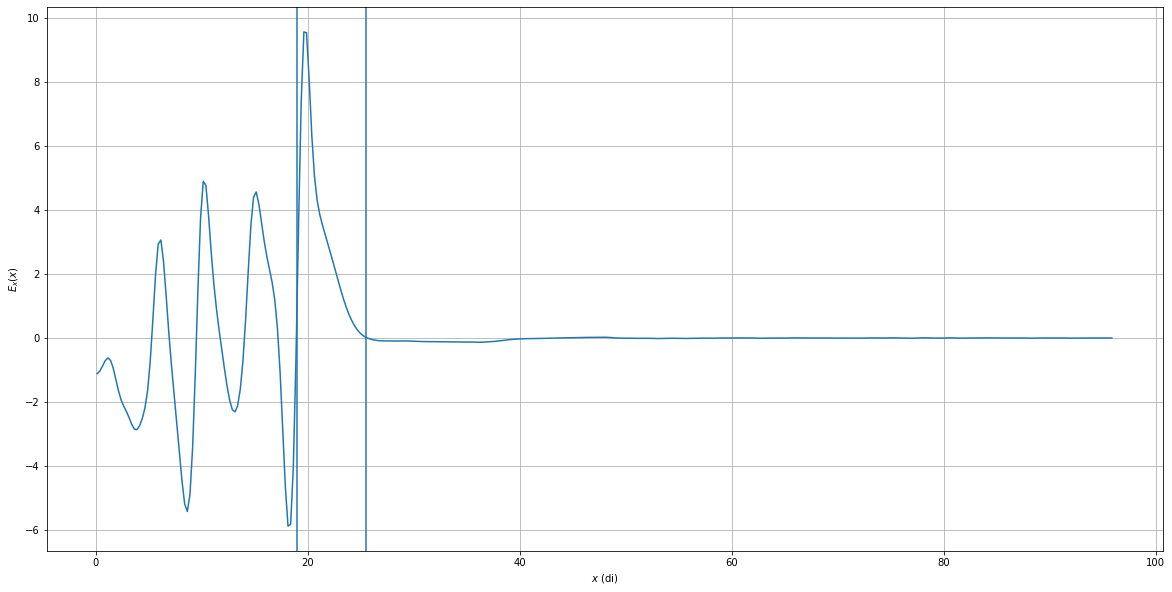

In [16]:
#option one, use Ex(x,y=0,z=0) to find SDA bounds. Should range from the start of the ramp to the first zero crossing
yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval,flnm=resultsdir+resultstag+'shockbounds.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

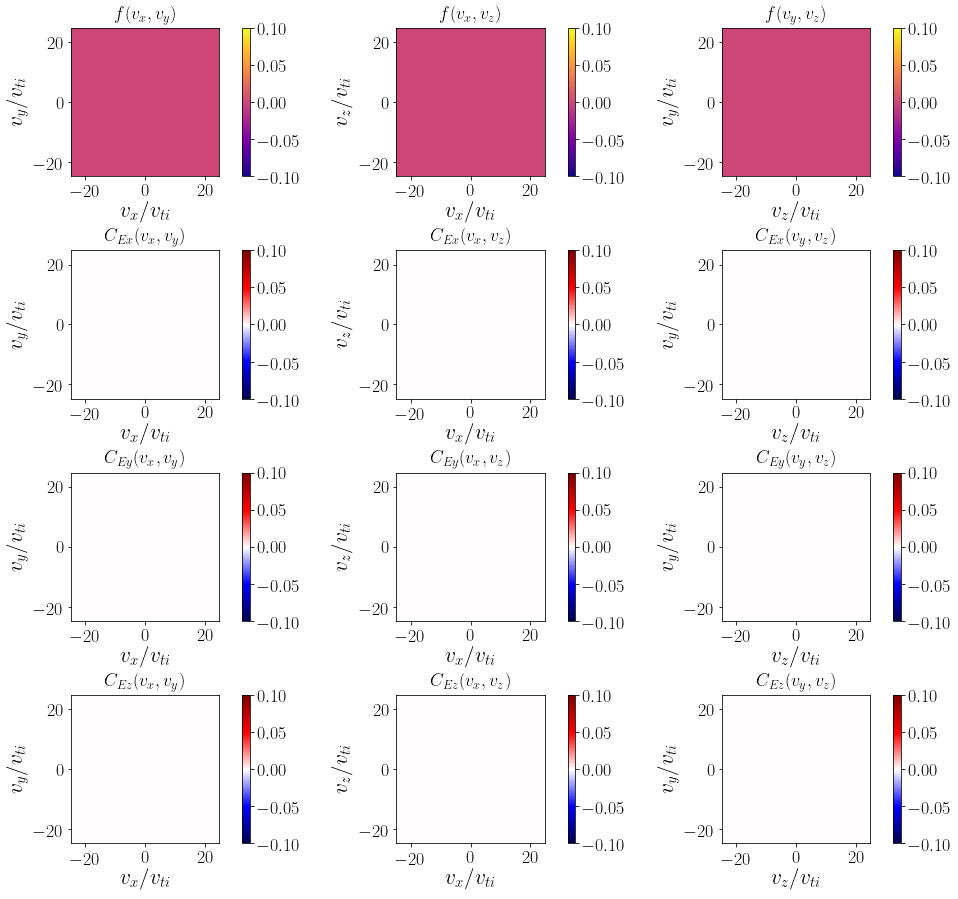

In [17]:
#option two (better but harder), look at the FPC signatures and see when the shock starts and stops

#Plot FPCs and dist funcs at start val-------------------------------------------------------------
#grab index of starval
i = ao.find_nearest(x, startval)

#Project onto 2d axis
H_xy = ao.array_3d_to_2d(Hist[i],'xy')
H_xz = ao.array_3d_to_2d(Hist[i],'xz')
H_yz = ao.array_3d_to_2d(Hist[i],'yz')
CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
CEx_xz = ao.array_3d_to_2d(CEx[i],'xz')
CEx_yz = ao.array_3d_to_2d(CEx[i],'yz')
CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
CEy_xz = ao.array_3d_to_2d(CEy[i],'xz')
CEy_yz = ao.array_3d_to_2d(CEy[i],'yz')
CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
CEz_xz = ao.array_3d_to_2d(CEz[i],'xz')
CEz_yz = ao.array_3d_to_2d(CEz[i],'yz')

#plot
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz,flnm=resultsdir+resultstag+'superplotstartval.png')
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

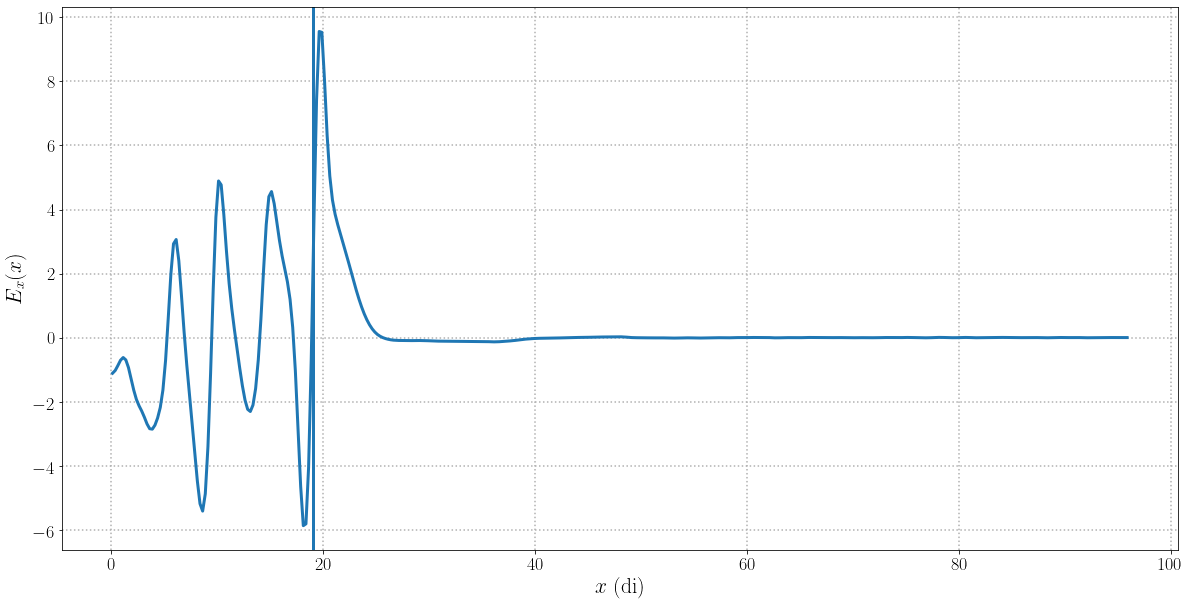

In [18]:
#plot where above signature is
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval,flnm=resultsdir+resultstag+'startvalpos.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval)

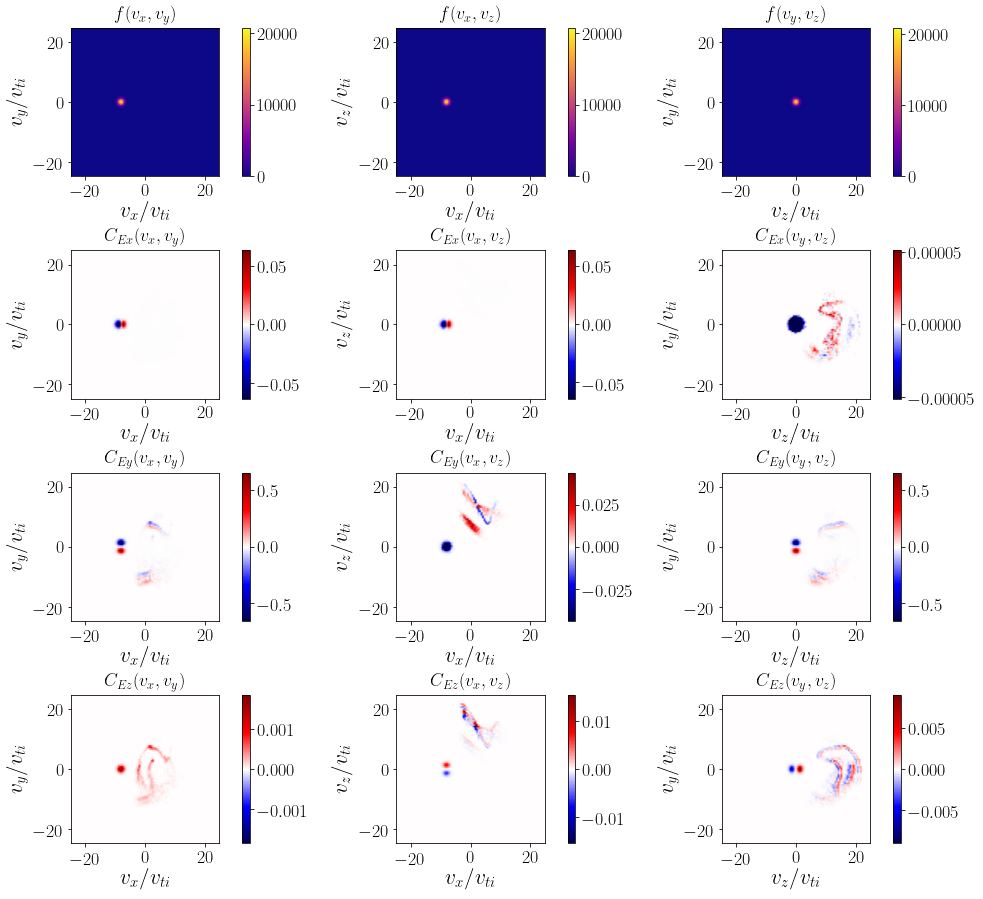

In [19]:
#Plot FPCs and dist funcs at end val--------------------------------------------------------------
#grab index of starval
i = ao.find_nearest(x, endval)

#Project onto 2d axis
H_xy = ao.array_3d_to_2d(Hist[i],'xy')
H_xz = ao.array_3d_to_2d(Hist[i],'xz')
H_yz = ao.array_3d_to_2d(Hist[i],'yz')
CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
CEx_xz = ao.array_3d_to_2d(CEx[i],'xz')
CEx_yz = ao.array_3d_to_2d(CEx[i],'yz')
CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
CEy_xz = ao.array_3d_to_2d(CEy[i],'xz')
CEy_yz = ao.array_3d_to_2d(CEy[i],'yz')
CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
CEz_xz = ao.array_3d_to_2d(CEz[i],'xz')
CEz_yz = ao.array_3d_to_2d(CEz[i],'yz')

#plot
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz,flnm=resultsdir+resultstag+'superplotendval.png')
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

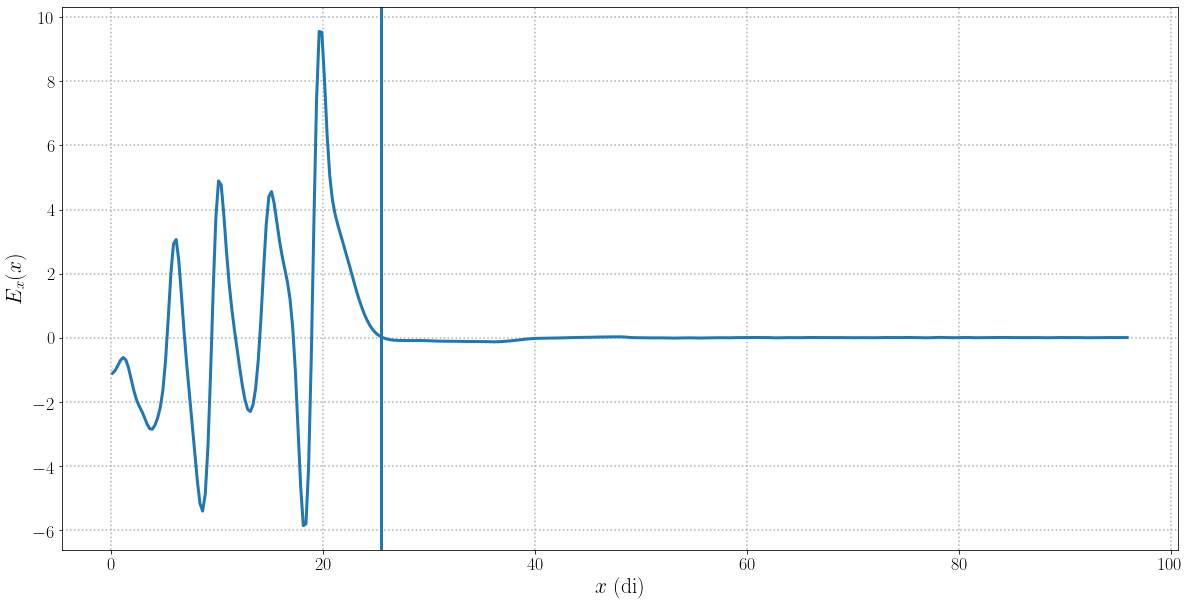

In [20]:
#plot where above signature is
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = endval,flnm=resultsdir+resultstag+'endvalpos.png')
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = endval)

In [21]:
#set metadata using add Metadata script
cmd = 'python3 ../scripts/addMetadata.py ' + analysisflnm + ' ' + ncflnm + ' ' + str(startval) + ' ' + str(endval)
os.system(cmd)

0

### Look for shock rippling

#### Make pmesh of fields

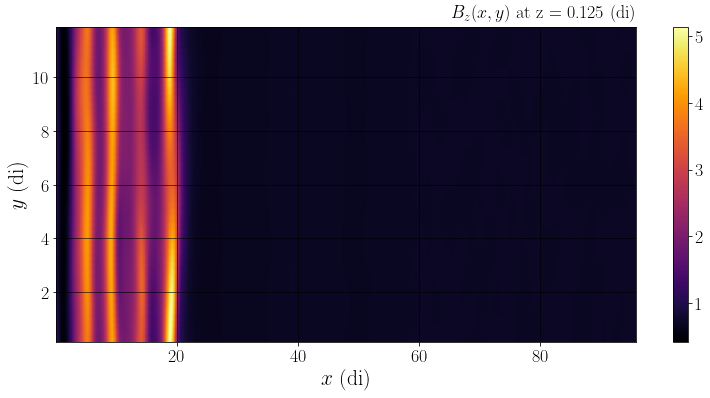

In [22]:
#plot xy plane at z=0 
plt2d.make_field_pmesh(dfields,'bz','xy',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=None,xlimmax=None,flnm=resultsdir+resultstag+'Bzpmesh.png')
plt2d.make_field_pmesh(dfields,'bz','xy',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=None,xlimmax=None)

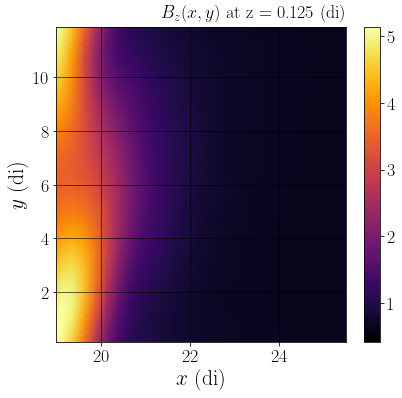

In [23]:
#zoom in on potential ripple xy plane at z=0
plt2d.make_field_pmesh(dfields,'bz','xy',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=startval,xlimmax=endval,flnm=resultsdir+resultstag+'Bzpeshzoomed.png')
plt2d.make_field_pmesh(dfields,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=startval,xlimmax=endval)

#### Make stacked line plot

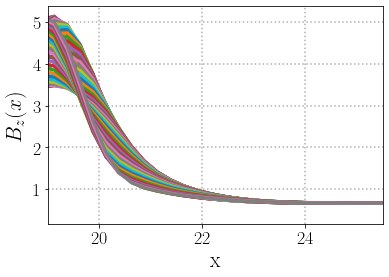

In [24]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=startval,xhigh=endval,flnm=resultsdir+resultstag+'stackedripple.png')
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=startval,xhigh=endval)

### Diagnose corrugation instability
#### look at number of significant wave modes in fourier space
#### still WIP

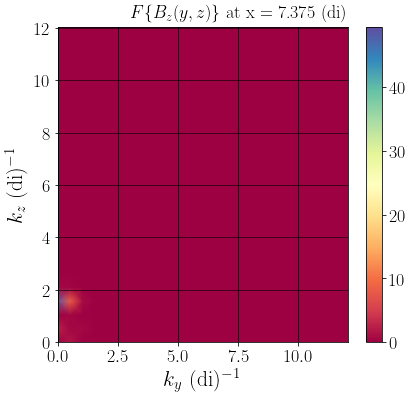

In [25]:
shockval = 15.0 #di, some slice in the ramp of the shock
i = ao.find_nearest(x, shockval)
pltfr.plot_fft_norm(dfields,'bz','yz',takeaxisaverage=False, xxindex=i, yyindex=float('nan'), zzindex=float('nan'), plotlog = False, xaxislim=None, yaxislim=None,flnm=resultsdir+resultstag+'2dfftinramp.png')
pltfr.plot_fft_norm(dfields,'bz','yz',flnm = '',takeaxisaverage=False, xxindex=i, yyindex=float('nan'), zzindex=float('nan'), plotlog = False, xaxislim=None, yaxislim=None)

### Generate sweep gifs

#### Generate sweeps of superplot

In [26]:
pltvv.make_superplot_gif(vx,vy,vz,vmax,Hist,CEx,CEy,CEz,x,resultsdir+'superplotscanfiles',resultsdir+resultstag+'superplot.gif')

Making plot 0 of 192
Making plot 1 of 192
Making plot 2 of 192
Making plot 3 of 192
Making plot 4 of 192
Making plot 5 of 192
Making plot 6 of 192
Making plot 7 of 192
Making plot 8 of 192
Making plot 9 of 192
Making plot 10 of 192
Making plot 11 of 192
Making plot 12 of 192
Making plot 13 of 192
Making plot 14 of 192
Making plot 15 of 192
Making plot 16 of 192
Making plot 17 of 192
Making plot 18 of 192
Making plot 19 of 192
Making plot 20 of 192
Making plot 21 of 192
Making plot 22 of 192
Making plot 23 of 192
Making plot 24 of 192
Making plot 25 of 192
Making plot 26 of 192
Making plot 27 of 192
Making plot 28 of 192
Making plot 29 of 192
Making plot 30 of 192
Making plot 31 of 192
Making plot 32 of 192
Making plot 33 of 192
Making plot 34 of 192
Making plot 35 of 192
Making plot 36 of 192
Making plot 37 of 192
Making plot 38 of 192
Making plot 39 of 192
Making plot 40 of 192
Making plot 41 of 192
Making plot 42 of 192
Making plot 43 of 192
Making plot 44 of 192
Making plot 45 of 19

In [27]:
rsltmng.make_gif_from_folder(resultsdir+'superplotscanfiles',resultsdir+resultstag+'superplot.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

In [28]:
plt1d.make_field_scan_gif(dfields,'ex',resultsdir+'fieldscanfiles',resultsdir+resultstag+'scan.gif')

Making plot 0 of 384
Making plot 1 of 384
Making plot 2 of 384
Making plot 3 of 384
Making plot 4 of 384
Making plot 5 of 384
Making plot 6 of 384
Making plot 7 of 384
Making plot 8 of 384
Making plot 9 of 384
Making plot 10 of 384
Making plot 11 of 384
Making plot 12 of 384
Making plot 13 of 384
Making plot 14 of 384
Making plot 15 of 384
Making plot 16 of 384
Making plot 17 of 384
Making plot 18 of 384
Making plot 19 of 384
Making plot 20 of 384
Making plot 21 of 384
Making plot 22 of 384
Making plot 23 of 384
Making plot 24 of 384
Making plot 25 of 384
Making plot 26 of 384
Making plot 27 of 384
Making plot 28 of 384
Making plot 29 of 384
Making plot 30 of 384
Making plot 31 of 384
Making plot 32 of 384
Making plot 33 of 384
Making plot 34 of 384
Making plot 35 of 384
Making plot 36 of 384
Making plot 37 of 384
Making plot 38 of 384
Making plot 39 of 384
Making plot 40 of 384
Making plot 41 of 384
Making plot 42 of 384
Making plot 43 of 384
Making plot 44 of 384
Making plot 45 of 38

Making plot 361 of 384
Making plot 362 of 384
Making plot 363 of 384
Making plot 364 of 384
Making plot 365 of 384
Making plot 366 of 384
Making plot 367 of 384
Making plot 368 of 384
Making plot 369 of 384
Making plot 370 of 384
Making plot 371 of 384
Making plot 372 of 384
Making plot 373 of 384
Making plot 374 of 384
Making plot 375 of 384
Making plot 376 of 384
Making plot 377 of 384
Making plot 378 of 384
Making plot 379 of 384
Making plot 380 of 384
Making plot 381 of 384
Making plot 382 of 384
Making plot 383 of 384


In [29]:
rsltmng.make_gif_from_folder(resultsdir+'fieldscanfiles',resultsdir+resultstag+'fieldscan.gif')

['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009', '000010', '000011', '000012', '000013', '000014', '000015', '000016', '000017', '000018', '000019', '000020', '000021', '000022', '000023', '000024', '000025', '000026', '000027', '000028', '000029', '000030', '000031', '000032', '000033', '000034', '000035', '000036', '000037', '000038', '000039', '000040', '000041', '000042', '000043', '000044', '000045', '000046', '000047', '000048', '000049', '000050', '000051', '000052', '000053', '000054', '000055', '000056', '000057', '000058', '000059', '000060', '000061', '000062', '000063', '000064', '000065', '000066', '000067', '000068', '000069', '000070', '000071', '000072', '000073', '000074', '000075', '000076', '000077', '000078', '000079', '000080', '000081', '000082', '000083', '000084', '000085', '000086', '000087', '000088', '000089', '000090', '000091', '000092', '000093', '000094', '000095', '000096', '000097', '000098', '000099',